<a href="https://colab.research.google.com/github/amartyacodes/ISRO-Internship/blob/main/GPM_DPR_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install h5py

In [ ]:
"""
gpm.py is a Python program written by PPS to provide an introduction
to reading the HDF5 files from the Global Precipitation Mission (GPM).
Documentation for this Python program is available one the PPS
homepage, http://pps.gsfc.nasa.gov .
"""
#
#	Filename:	gpm.py
#
#	Date:		16 June 2015
#
#	Purpose:	To read and display a GPM HDF5 swath variable
#      			in python
#
#	Author:    	Owen Kelley for NASA/GSFC
#
# All rights to code held by NASA/GSFC Precipitation
# Processing System
#
#	Notes:
#
# To load this code into your python session, use "import gpm"
# with this source file in your current working directory.
# If you edit this source file and want to load the updated
# version in an existing python session, use "reload(gpm)".
#
# If you see a function in this source file that you want to
# run, be sure to append "gpm." before the function name in
# the python session inwhich you typed "import gpm".  For
# example, type "gpm.listContents( file ) where file is the 
# name of a GPM HDF5 file.
#
# On Windows: To change the current working directory to the
# directory where your data files are located, use:
#   import os
#   os.chdir( 'C:\\aFolder\\aSubfolder\\myPythonProjects' )
#

#------------------------------------
#  import modules
#------------------------------------

import numpy

try:
  import h5py
except ImportError:
  print ('please install the h5py module', \
    'so that you will have HDF5 access in python')

import matplotlib

import matplotlib.pyplot as plt

def readSwath( fileName, varName, swath ) :
  #------------------------------------
  #  
  #------------------------------------
  print ('readSwath: ' + fileName)
  #
  # --- verify that requested variable is available
  #
  fileHandle = h5py.File( fileName, 'r' )
  varExists = varName in fileHandle
  if varExists == False :
    print ('Error: requested variable does not exist in file')
    print ('  ', fileName)
    print ('  ', varName)
    return
  #
  # --- read data
  #
  swath['data'] = fileHandle[ varName ]
  #
  # --- first try at lat/lon array names (GMI)
  #
  rootName = varName.rpartition( '/' )[0]
  latName = rootName + '/Latitude'
  lonName = rootName + '/Longitude'
  #
  # --- see if lat exists
  #
  latExists = latName in fileHandle
  #
  # --- optional second try at lat/lon array names (DPR)
  #
  if latExists == False :
    rootName = rootName.rpartition( '/' )[0]
    latName = rootName + '/Latitude'
    lonName = rootName + '/Longitude'
  #
  # --- read lat/lon arrays
  #
  swath['lat'] = fileHandle[ latName ]
  swath['lon'] = fileHandle[ lonName ]


def plotSwath( swath, swathRange=None ) :
  #------------------------------------
  #  
  #------------------------------------
  print ('plotSwath: close plot window to continue')
  #
  # --- extract data
  #
  s = swathRange
  lat = swath['lat']
  lon = swath['lon']
  data = swath['data']
  #
  # --- subset data and lat/lon if requested, otherwise
  #     just convert from h5py dataset object to numpy 
  #     array object.  Warning this assumes that you read
  #     a 2D dataset, whereas some datasets in GPM HDF5 files
  #     are 3D, 4D, etc.
  #
  if s != None :
    lat = lat[ s[0]:s[1], :: ]
    lon = lon[ s[0]:s[1], :: ]
    data = data[ s[0]:s[1], :: ]
  else:
    lat = lat[ ::, ::]
    lon = lon[ ::, ::]
    data = data[ ::, ::]
    print(data.shape)
  #
  # --- convert ge0 values into a 1D array
  #
  indexPlot = data > 0
  lat = lat[ indexPlot ]
  lon = lon[ indexPlot ]
  data = data[ indexPlot ]
  #
  # --- define (1D+1) color array
  #
  color = numpy.log10( data )
  color = color - numpy.amin( color )
  color = 1.0 * color / numpy.amax( color )
  color = plt.cm.jet( color )
  #
  # --- create title.  take advantage of the fact that
  #     the swath lat variable is actually an h5py object
  #     that carries the name of the HDF5 file inside it
  #
  title = swath['data'].file.filename
  #
  # --- display scatter plot 
  #
  plotHandle = plt.scatter( lon, lat, color=color )
  plt.xlabel( 'E. Longitude' ) ; plt.ylabel( 'N. Latitude' )
  plt.title( title )
  # --- text relative to plot window, not data axes
  plt.figtext( 0,0, 'plt.scatter' )
  # --- create a color bar
  plotHandle.set_clim([0,1])
  plt.colorbar(plotHandle)
  # --- render the image on the screen now
  plt.legend()
  plt.show( )


def readGrid( fileName, varName, grid ) :
  #------------------------------------
  #  
  #------------------------------------
  print ('readGrid: ' + fileName)
  #
  # --- verify that requested variable is available
  #
  fileHandle = h5py.File( fileName, 'r' )
  varExists = varName in fileHandle
  if varExists == False :
    print ('Error: requested variable does not exist in file')
    print ('  ', fileName)
    print ('  ', varName)
    return
  #
  # --- read data
  #
  grid['data'] = fileHandle[ varName ]


def plotGrid( grid ) :
  #------------------------------------
  #  
  #------------------------------------
  print ('plotGrid: close plot window to continue')
  #
  # --- lat/lon dimensions must be refers so lon is x, lat is y
  #
  data = numpy.fliplr( grid['data'] )
  data = numpy.transpose( data )
  #
  # --- color array
  norm = matplotlib.colors.Normalize(vmin=-1,vmax=1)
  color = numpy.log10( data )
  #
  # --- generate image and colorbar
  #
  image = plt.imshow( color, \
    interpolation='nearest', norm=norm)
  #
  # --- add labels and color bar
  #
  plt.xlabel( 'E. Longitude' ) ; plt.ylabel( 'N. Latitude' )
  title = grid['data'].file.filename
  plt.title( title )
  barHandle = plt.colorbar( image, norm=norm )
  barHandle.set_label( 'log10( mm/hour )' )
  plt.legend()
  plt.show()


def listNode( name, obj ) :
  #------------------------------------
  #  
  #------------------------------------
  global GLOBALoutputFile
  #
  if GLOBALoutputFile != None :
    outputTextFile = open( GLOBALoutputFile, 'a' )
  #
  # --- for all datasets (not groups or files) print info
  #
  if isinstance( obj, h5py.Dataset ) :
    if GLOBALoutputFile == None :
      print('/' + name, '  ',  obj.dtype, obj.shape)
    else :
      aString = str( '/' + name + '  ' + str(obj.dtype) + \
        str(obj.shape) )
      outputTextFile.write( aString + '\n' )
  #
  # --- if this is a group object with a GridHeader annotation
  #	print the annotation
  #
  if 'GridHeader' in obj.attrs :
    gridHeader = obj.attrs['GridHeader']
    if GLOBALoutputFile == None :
      print(obj.name + ' GridHeader attribute:')
      print( gridHeader)
    else :
      outputTextFile.write( obj.name + ' GridHeader attribute:\n' )
      outputTextFile.write( gridHeader +'\n' )
  #
  if GLOBALoutputFile != None :
    outputTextFile.close( )


def listContents( fileName, outputFile=None ) :
  '''
  Obtain a text list of the variables in an HDF5 file.
  '''
  #------------------------------------
  #  
  #------------------------------------
  print ('listContents: ' + fileName)
  global GLOBALoutputFile
  #
  GLOBALoutputFile = outputFile
  #
  if GLOBALoutputFile != None :
    print ('writing output to ', GLOBALoutputFile)
    outputTextFile = open( GLOBALoutputFile, 'w' )
    outputTextFile.write( 'file: ' + fileName +'\n\n' )
    outputTextFile.close( )
  #
  fileHandle = h5py.File( fileName, 'r' )
  fileHandle.visititems( listNode )


def testRun():
  '''
  Run this function to test some of the read and display functions
  in this Python module.
  '''
  #------------------------------------
  #  
  #------------------------------------
  print ('testRun: ')
  #
  # --- initialize dictionaries
  #
  swath = { 'lat': -9, 'lon': -9, 'data': -9 }
  grid = { 'data': -9, 'latRange': -9, 'lonRange': -9 }
  #
  gprofFile = \
    '2A.GPM.GMI.GPROF.20140409-S190623-E191330.000640.V03C.subset.HDF5'
  dprFile = \
    '/content/GPMCOR_DPR_1403190309_0441_000303_L2S_DD2_05A.h5'
  imergFile = \
    '3B-HHR.MS.MRG.3IMERG.20140409-S190000-E192959.1140.V03D.HDF5'
  #
  # --- GMI swath
  #
  # readSwath( gprofFile, '/S1/surfacePrecipitation', swath )
  # plotSwath( swath )
  #
  # --- DPR swath
  #
  readSwath( dprFile, '/NS/PRE/binStormTop', swath )
  plotSwath( swath)
  #, [100,325] 
  # --- IMERG grid
  #
  # readGrid( imergFile, '/Grid/precipitationCal', grid )
  # plotGrid( grid )
  #
  # ---- dump list of objects to screen or to a text file
  #
  # listContents( imergFile, outputFile='h5dump.txt' )


#------------------------------------
#    main line
#------------------------------------

# print ' '
# print 'usage: gpm.testRun()'
# print ' '



No handles with labels found to put in legend.


testRun: 
readSwath: /content/GPMCOR_DPR_1403190309_0441_000303_L2S_DD2_05A.h5
plotSwath: close plot window to continue
(7923, 49)


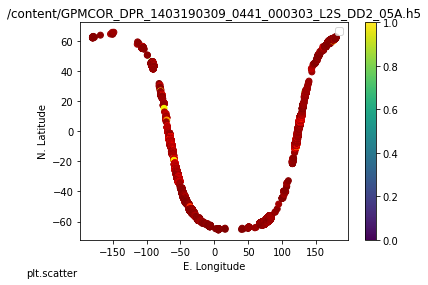

In [ ]:
testRun()